In [1]:
from scripts.util import get_env_variables
from os.path import join
import os
import pandas as pd
from scripts.presentation import parse_results_from_file
results_folder = get_env_variables('RESULTS')
results = join(results_folder, 'results')
dfs_comet = []
for fi in os.listdir(results):
    if not fi.startswith('comet'): continue
    file_path = join(results, fi)
    df = parse_results_from_file(file_path)
    dfs_comet.append(df)

df_bert = parse_results_from_file(join(results, 'bert-f1.csv'))
df_bert_opus = parse_results_from_file(join(results, 'bert-f1-opus.csv'))
df_comet = pd.concat(dfs_comet, ignore_index=True)
df_bert = pd.concat([df_bert, df_bert_opus], ignore_index=True)

len(df_bert), len(df_comet)


(480, 480)

In [2]:
df = pd.merge(df_bert, df_comet, on=['dataset', 'translator', 'src_lang', 'tgt_lang', 'BLEU', 'chrF'])
# Proves that BERT-F1 and COMET were computed on the same exact translations, otherwise impossible to have identical BLEU and chrF
df.to_csv('final_results.csv', index=False)
len(df)

480

# RQ1

In [3]:
from scripts.presentation import aggregate_matrices, plot_vectors, form_matrices
labels = {'ep-deepl': 'DeepL', 'ep-gpt': 'GPT-4.1', 'base':'Koehn-SMT'}
colors = {'ep-deepl': '#D83838', 'ep-gpt': '#39C04B', 'base':'#0C3A1B'}
matrices = form_matrices(df, 'BLEU', ['deepl', 'gpt'], ['ep', 'ep'])

aggr_vectors1 = {}
aggr_vectors2 = {}
for m in ['INTO', 'FROM', 'DIFF']:
    aggr = aggregate_matrices(matrices, mode=m, include_base=True)
    deepl_mean_diff = aggr['ep-deepl'].mean()
    gpt_mean_diff = aggr['ep-gpt'].mean()
    print(f'{m}: {deepl_mean_diff:.1f}, {gpt_mean_diff:.1f}')
    aggr_vectors1[m] = aggr
    aggr = aggregate_matrices(matrices, mode=m, include_base=False)
    aggr_vectors2[m] = aggr


INTO: 7.3, 4.2
FROM: 7.3, 4.2
DIFF: -0.0, -0.0


In [4]:
mean_bleu_comparison = {}
for m in ['INTO', 'FROM']:
    cols = aggr_vectors1[m]
    for col in cols:
        if col == 'base':
            key = f'{m}-base'
        else:
            key = f'Δ{m}-{col}'
        mean_bleu_comparison[key] = cols[col]

mean_bleu_comparison = pd.DataFrame(mean_bleu_comparison)
mean_bleu_comparison = mean_bleu_comparison[[
    'FROM-base', 'INTO-base', 'ΔFROM-ep-deepl', 'ΔINTO-ep-deepl', 'ΔFROM-ep-gpt', 'ΔINTO-ep-gpt']]

# print(mean_bleu_comparison.to_latex(float_format='%.1f'))
mean_bleu_comparison

,FROM-base,INTO-base,ΔFROM-ep-deepl,ΔINTO-ep-deepl,ΔFROM-ep-gpt,ΔINTO-ep-gpt
lang,,,,,,
da,23.3,23.3,8.9,10.3,5.6,8.8
sv,24.8,22.1,6.7,6.3,2.8,3.9
de,22.2,17.7,9.2,12.5,5.9,10.2
nl,19.7,20.7,6.3,8.3,4.4,4.7
en,23.8,27.4,9.4,10.2,4.7,5.4
es,26.7,29.6,6.8,6.4,3.9,4.1
fr,26.1,31.2,4.9,4.7,2.8,0.7
it,24.3,25.4,3.9,2.2,0.6,-0.2
pt,26.1,27.0,5.5,4.5,2.6,-0.4


In [5]:
tmp = {}
for m in ['INTO', 'FROM']:
    cols = aggr_vectors2[m]
    for col in cols:
        if col == 'base':
            continue
        key = f'{m}-{col}'
        tmp[key] = cols[col]

tmp = pd.DataFrame(tmp)
mean_bleu_comparison = pd.merge(mean_bleu_comparison, tmp, on='lang')

In [6]:
diff_outliers = {m: [] for m in mean_bleu_comparison if 'Δ' in m}
diff_outliers['Label'] = ['Mean', 'SD', 'High Outliers', 'Low Outliers']
for m in mean_bleu_comparison:
    mbc = mean_bleu_comparison
    if 'Δ' in m:
        mean = mbc[m].mean()
        std = mbc[m].std()
        outliers = mbc[abs(mbc[m] - mean) > 2*std]
        high_outliers = outliers[outliers[m] > mean].index.tolist()
        low_outliers = outliers[outliers[m] < mean].index.tolist()
        row = [mean, std, high_outliers, low_outliers]
        diff_outliers[m] = row


diff_outliers = pd.DataFrame(diff_outliers)
diff_outliers.set_index('Label', inplace=True)

# ChatGPT Aided
# How to format a list as a set in LaTeX
def format_as_latex_set(x):
    if isinstance(x, list):
        return r'\{' + ', '.join(x) + r'\}'
    return x

diff_outliers = diff_outliers.map(format_as_latex_set)
#print(diff_outliers.to_latex(float_format='%.2f'))
diff_outliers

,ΔFROM-ep-deepl,ΔINTO-ep-deepl,ΔFROM-ep-gpt,ΔINTO-ep-gpt
Label,,,,
Mean,7.3,7.318182,4.218182,4.236364
SD,2.05621,3.283845,1.91928,3.42528
High Outliers,\{\},\{\},\{\},\{\}
Low Outliers,\{\},\{\},\{\},\{\}


In [7]:
diff_outliers = {m: [] for m in mean_bleu_comparison if not 'Δ' in m}
diff_outliers['Label'] = ['Mean', 'SD', 'High Outliers', 'Low Outliers']
for m in mean_bleu_comparison:
    mbc = mean_bleu_comparison
    if not 'Δ' in m:
        mean = mbc[m].mean()
        std = mbc[m].std()
        outliers = mbc[abs(mbc[m] - mean) > std]
        high_outliers = outliers[outliers[m] > mean].index.tolist()
        low_outliers = outliers[outliers[m] < mean].index.tolist()
        row = [mean, std, high_outliers, low_outliers]
        diff_outliers[m] = row


diff_outliers = pd.DataFrame(diff_outliers)
diff_outliers.set_index('Label', inplace=True)

def format_as_latex_set(x):
    if isinstance(x, list):
        return r'\{' + ', '.join(x) + r'\}'
    return x

diff_outliers = diff_outliers.map(format_as_latex_set)
#print(diff_outliers.to_latex(float_format='%.2f'))
diff_outliers

,FROM-base,INTO-base,INTO-ep-deepl,INTO-ep-gpt,FROM-ep-deepl,FROM-ep-gpt
Label,,,,,,
Mean,23.627273,23.609091,30.927273,27.854545,30.918182,27.872727
SD,2.482374,5.426685,4.456252,4.459454,2.276321,2.001545
High Outliers,\{es\},"\{es, fr\}","\{en, es, fr\}","\{en, es\}","\{en, es\}",\{es\}
Low Outliers,"\{nl, fi\}","\{de, fi\}",\{fi\},\{fi\},"\{nl, it\}","\{nl, it\}"


INTO


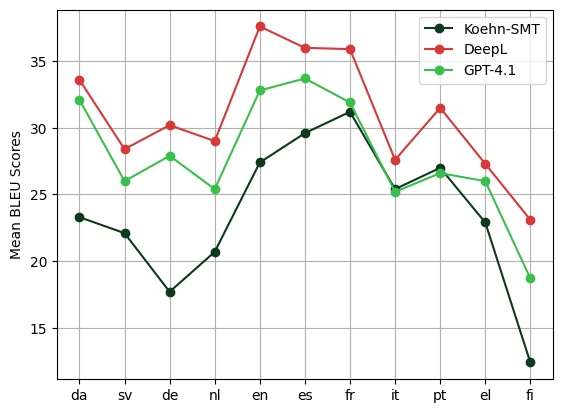

FROM


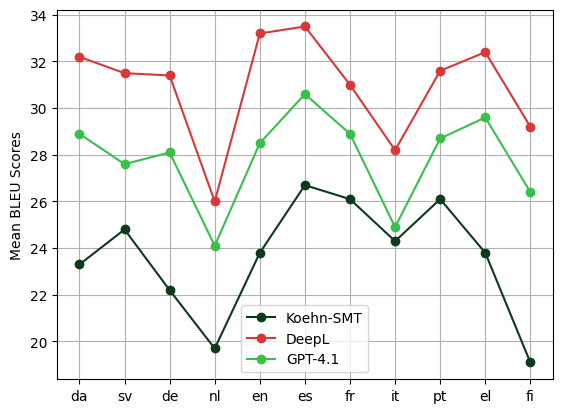

DIFF


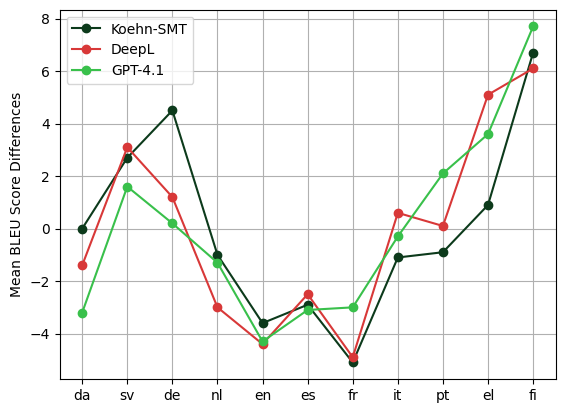

In [8]:
for k in aggr_vectors1:
    print(k)
    label = 'Mean BLEU Scores'
    if k == 'DIFF':
        label = 'Mean BLEU Score Differences'
    plot_vectors(aggr_vectors1[k], label_map=labels, color_map=colors, include_base=True, ylabel=label)


In [9]:
import numpy as np
aggr_vectors1['DIFF']
diff_outliers = {m: [] for m in aggr_vectors1['DIFF']}
diff_outliers['Label'] = ['Mean', 'SD', 'High Outliers', 'Low Outliers']
for m in aggr_vectors1['DIFF']:
    mbc = aggr_vectors1['DIFF']
    if not 'Δ' in m:
        mean = mbc[m].mean()
        std = mbc[m].std()
        outliers = mbc[abs(mbc[m] - mean) > std]
        high_outliers = outliers[outliers[m] > mean].index.tolist()
        low_outliers = outliers[outliers[m] < mean].index.tolist()
        row = [mean, std, high_outliers, low_outliers]
        diff_outliers[m] = row


diff_outliers = pd.DataFrame(diff_outliers)
diff_outliers.set_index('Label', inplace=True)
diff_outliers.rename(columns=labels, inplace=True)
diff_outliers

,DeepL,GPT-4.1,Koehn-SMT
Label,,,
Mean,-0.018182,-0.018182,0.018182
SD,1.993398,2.299921,3.516196
High Outliers,[el],"[pt, el]","[de, fi]"
Low Outliers,[de],"[da, de]","[en, fr]"


DeepL


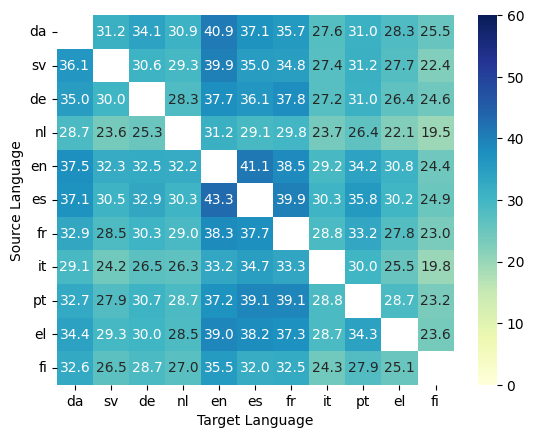

GPT-4.1


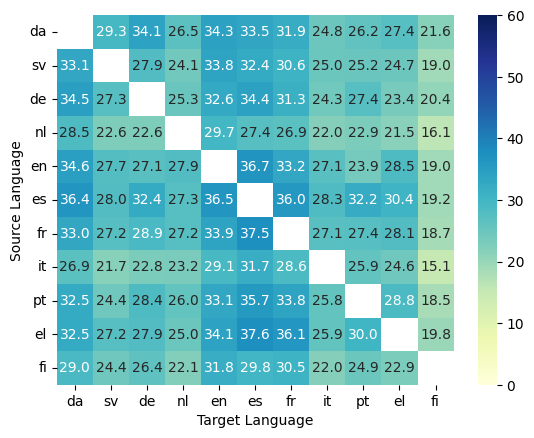

Koehn-SMT


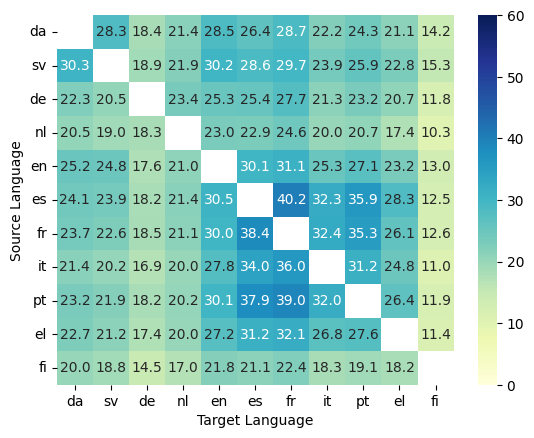

In [10]:
from scripts.presentation import plot_matrix, get_base_score_matrix
matrices['base'] = get_base_score_matrix()
for m in matrices:
    k = '-'.join(m) if type(m)==tuple else m
    print(labels[k])
    plot_matrix(matrices[m], vmin=0, vmax=60)

# RQ2

In [11]:
from scripts.presentation import correlations
import pandas as pd
corr_data = {
    'Pearson': [],
    'Spearman': [],
    'Pearson-p':[],
    'Spearman-p':[],
    'Dataset':[],
    'Translator':[],
    'Metrix x':[],
    'Metrix y':[]
}
def set_data(p, pp, s, sp, mx, my, d, t):
    corr_data['Pearson'].append(p)
    corr_data['Spearman'].append(s)
    corr_data['Pearson-p'].append(pp)
    corr_data['Spearman-p'].append(sp)
    corr_data['Metrix x'].append(mx)
    corr_data['Metrix y'].append(my)
    corr_data['Dataset'].append(d)
    corr_data['Translator'].append(t)

for t in ['deepl', 'gpt']:
    for d in ['ep', 'flores']:
        config1 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BLEU'
        }
        config2 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'chrF'
        }
        config3 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'COMET'
        }
        config4 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BERT-F1'
        }
        pearson, pearson_p, spearman, spearman_p = correlations(df, config1, config2)
        set_data(pearson, pearson_p, spearman, spearman_p, 'BLEU', 'chrF', d, t)

        pearson, pearson_p, spearman, spearman_p = correlations(df, config1, config3)
        set_data(pearson, pearson_p, spearman, spearman_p, 'BLEU', 'COMET', d, t)
        
        pearson, pearson_p, spearman, spearman_p = correlations(df, config1, config4)
        set_data(pearson, pearson_p, spearman, spearman_p, 'BLEU', 'BERT-F1', d, t)


corr_df = pd.DataFrame(corr_data)
labels = {'ep': 'Europarl', 'flores': 'FLORES+', 'gpt': 'GPT-4.1', 'deepl': 'DeepL'}
corr_df.replace(labels, inplace=True)
corr_df.sort_values(by='Pearson', ascending=True, key=abs)


def format_sci_notation(x):
    float_string = f"{x:.1e}"
    coeff, exponent = float_string.split('e')
    exponent = int(exponent)
    return f"${coeff} \\times 10^{{{exponent}}}$"

def format_sign(x):
    return f'${x:.2f}$'

corr_df['Pearson-p'] = corr_df['Pearson-p'].apply(format_sci_notation)
corr_df['Spearman-p'] = corr_df['Spearman-p'].apply(format_sci_notation)
corr_df['Pearson'] = corr_df['Pearson'].apply(format_sign)
corr_df['Spearman'] = corr_df['Spearman'].apply(format_sign)
corr_df = corr_df[['Dataset', 'Translator', 'Metrix x', 'Metrix y', 'Pearson', 'Pearson-p', 'Spearman', 'Spearman-p']]
# print(corr_df.to_latex(index=False, float_format='%.2f'))
corr_df


,Dataset,Translator,Metrix x,Metrix y,Pearson,Pearson-p,Spearman,Spearman-p
0,Europarl,DeepL,BLEU,chrF,$0.84$,$4.1 \times 10^{-31}$,$0.85$,$1.5 \times 10^{-31}$
1,Europarl,DeepL,BLEU,COMET,$-0.32$,$6.4 \times 10^{-4}$,$-0.27$,$4.5 \times 10^{-3}$
2,Europarl,DeepL,BLEU,BERT-F1,$0.93$,$4.2 \times 10^{-50}$,$0.93$,$7.6 \times 10^{-49}$
3,FLORES+,DeepL,BLEU,chrF,$0.94$,$5.3 \times 10^{-53}$,$0.92$,$4.9 \times 10^{-47}$
4,FLORES+,DeepL,BLEU,COMET,$0.29$,$2.4 \times 10^{-3}$,$0.26$,$7.0 \times 10^{-3}$
5,FLORES+,DeepL,BLEU,BERT-F1,$0.96$,$2.3 \times 10^{-60}$,$0.94$,$3.2 \times 10^{-53}$
6,Europarl,GPT-4.1,BLEU,chrF,$0.88$,$4.2 \times 10^{-36}$,$0.89$,$2.6 \times 10^{-39}$
7,Europarl,GPT-4.1,BLEU,COMET,$-0.27$,$4.1 \times 10^{-3}$,$-0.18$,$6.4 \times 10^{-2}$
8,Europarl,GPT-4.1,BLEU,BERT-F1,$0.89$,$1.3 \times 10^{-39}$,$0.91$,$1.0 \times 10^{-43}$
9,FLORES+,GPT-4.1,BLEU,chrF,$0.95$,$6.4 \times 10^{-55}$,$0.93$,$4.2 \times 10^{-49}$


In [12]:
import pandas as pd
from scripts.presentation import linear_regression, top_n_residuals, mark_residual_by_src_or_tgt_freq
linear_reg_outliers = {
    'dataset': [],
    'translator': [],
    'metric x': [],
    'metric y': [],
    'src outliers': [],
    'tgt outliers': []
}

for m in ['chrF', 'COMET', 'BERT-F1']:
    for t in ['deepl', 'gpt']:
        for d in ['ep', 'flores']:
            config1 = {
                'datasets': [d],
                'translators': [t],
                'src_lang': None,
                'tgt_lang': None,
                'metric': 'BLEU'
            }
            config2 = {
                'datasets': [d],
                'translators': [t],
                'src_lang': None,
                'tgt_lang': None,
                'metric': m
                }
            data, model = linear_regression(
                df, config1, config2, x_label='BLEU', y_label=m, plot=False)
            outliers = top_n_residuals(data, model, top_n=20)
            custom_col, top = mark_residual_by_src_or_tgt_freq(outliers, n=4)
            src_outliers = [t[4:] for t, _ in top if t.startswith('src')]
            tgt_outliers = [t[4:] for t, _ in top if t.startswith('tgt')]
            linear_reg_outliers['dataset'].append(d)
            linear_reg_outliers['translator'].append(t)
            linear_reg_outliers['metric x'].append('BLEU')
            linear_reg_outliers['metric y'].append(m)
            linear_reg_outliers['src outliers'].append(src_outliers)
            linear_reg_outliers['tgt outliers'].append(tgt_outliers)



linear_reg_outliers = pd.DataFrame(linear_reg_outliers)




linear_reg_outliers = linear_reg_outliers.map(format_as_latex_set)
linear_reg_outliers.replace(labels, inplace=True)
linear_reg_outliers
#print(linear_reg_outliers.to_latex(index=False))


,dataset,translator,metric x,metric y,src outliers,tgt outliers
0,Europarl,DeepL,BLEU,chrF,"\{nl, fr\}","\{fi, el\}"
1,FLORES+,DeepL,BLEU,chrF,"\{sv, nl\}","\{fi, el\}"
2,Europarl,GPT-4.1,BLEU,chrF,\{nl\},"\{el, fi, de\}"
3,FLORES+,GPT-4.1,BLEU,chrF,"\{nl, sv\}","\{fi, el\}"
4,Europarl,DeepL,BLEU,COMET,"\{nl, en\}","\{fi, da\}"
5,FLORES+,DeepL,BLEU,COMET,"\{nl, el\}","\{fi, es\}"
6,Europarl,GPT-4.1,BLEU,COMET,"\{nl, en, it\}",\{fi\}
7,FLORES+,GPT-4.1,BLEU,COMET,"\{nl, es\}","\{fi, es\}"
8,Europarl,DeepL,BLEU,BERT-F1,"\{it, el\}","\{fi, nl\}"
9,FLORES+,DeepL,BLEU,BERT-F1,"\{en, es\}","\{pt, el\}"


Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : chrF
Pearson correlation: 0.84 (p = 4.1e-31)
Spearman correlation: 0.85 (p = 1.5e-31)
Outliers:  [('tgt-fi', 8), ('tgt-el', 7), ('src-nl', 4), ('src-fr', 3)]


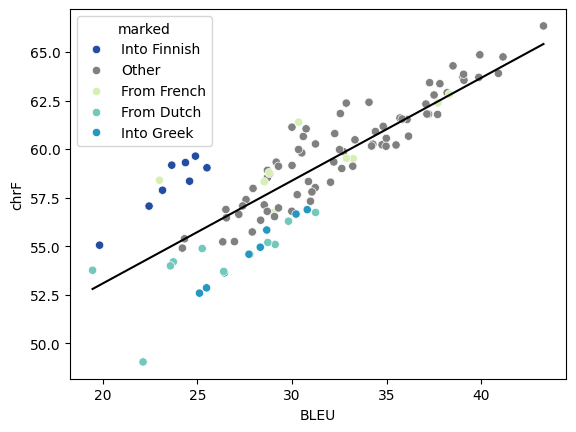

Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : chrF
Pearson correlation: 0.84 (p = 4.1e-31)
Spearman correlation: 0.85 (p = 1.5e-31)
Outliers:  [('tgt-fi', 8), ('tgt-el', 7), ('src-nl', 4), ('src-fr', 3)]


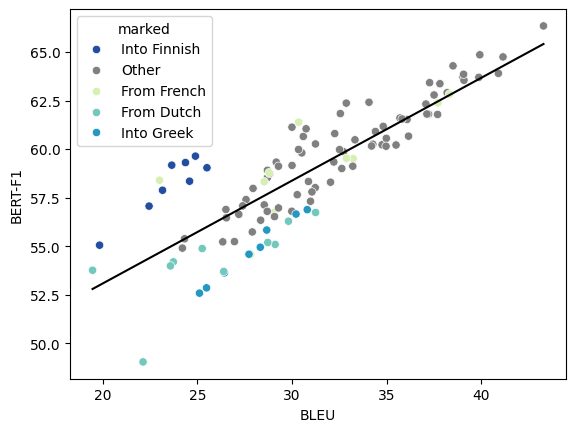

In [13]:
from scripts.presentation import linear_regression, top_n_residuals, mark_residual_by_src_or_tgt_freq
for m in ['chrF', 'BERT-F1']:
    config1 = {
        'datasets': ['ep'],
        'translators': ['deepl'],
        'src_lang': None,
        'tgt_lang': None,
        'metric': 'BLEU'

    }
    config2 = {
        'datasets': ['ep'],
        'translators': ['deepl'],
        'src_lang': None,
        'tgt_lang': None,
        'metric': 'chrF'
    }
    correlations(df, config1, config2, show=True)
    data, model = linear_regression(df, config1, config2, x_label='BLEU', y_label=m, plot=False)
    outliers = top_n_residuals(data, model, top_n=20)
    custom_col, top = mark_residual_by_src_or_tgt_freq(outliers, n=4)
    print('Outliers: ', top)
    data, model = linear_regression(df, config1, config2, x_label='BLEU', y_label=m, custom_color=custom_col)


In [14]:
# mark_residual_by_src_or_tgt_freq selects them from here: 
print(outliers['src_lang'].value_counts().head(3))
print(outliers['tgt_lang'].value_counts().head(3))

src_lang
nl    4
fr    3
el    2
Name: count, dtype: int64
tgt_lang
fi    8
el    7
de    2
Name: count, dtype: int64


Datasets: ['ep'] : ['ep']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : COMET
Pearson correlation: -0.27 (p = 4.1e-03)
Spearman correlation: -0.18 (p = 6.4e-02)
Outliers:  [('tgt-fi', 5), ('src-nl', 4), ('src-en', 3), ('src-it', 3)]


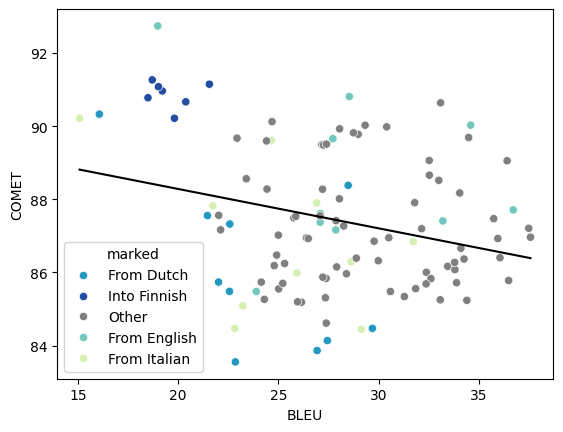

Datasets: ['flores'] : ['flores']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : COMET
Pearson correlation: 0.29 (p = 2.2e-03)
Spearman correlation: 0.25 (p = 8.3e-03)
Outliers:  [('tgt-fi', 10), ('tgt-es', 6), ('src-nl', 3), ('src-es', 3)]


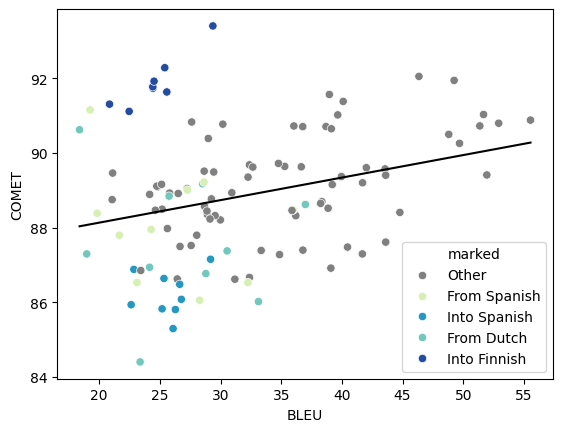

In [15]:
from scripts.presentation import linear_regression, top_n_residuals, mark_residual_by_src_or_tgt_freq
for d in ['ep', 'flores']:
    config1 = {
        'datasets': [d],
        'translators': ['gpt'],
        'src_lang': None,
        'tgt_lang': None,
        'metric': 'BLEU'

    }
    config2 = {
        'datasets': [d],
        'translators': ['gpt'],
        'src_lang': None,
        'tgt_lang': None,
        'metric': 'COMET'
    }
    correlations(df, config1, config2, show=True)
    data, model = linear_regression(
        df, config1, config2, x_label='BLEU', y_label='COMET', plot=False)
    outliers = top_n_residuals(data, model, top_n=20)
    custom_col, top = mark_residual_by_src_or_tgt_freq(outliers, n=4)
    print('Outliers: ', top)
    data, model = linear_regression(
        df, config1, config2, x_label='BLEU', y_label='COMET', custom_color=custom_col)

# RQ3

## General Patterns

In [16]:
from scripts.presentation import aggregate_matrices
import numpy as np
import pandas as pd
data = {
    'dataset x': [],
    'dataset y': [],
    'translator x': [],
    'translator y': [],
    'metric': [],
    'cosine sim': [],
    'mean diff': [],
    'direction': [],
    'same tl': [],
    'same ds': [],
}

combinations = set()
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
    for m in ['INTO', 'FROM']:
        agg = aggregate_matrices(matrices, mode=m, include_base=False)
        for d in ['ep', 'flores']:
            for t in ['deepl', 'gpt']:
                for d2 in ['ep', 'flores']:
                    for t2 in ['deepl', 'gpt']:
                        if (d == d2 and t == t2) or (d != d2 and t != t2):
                            continue
                        
                        comb = (d2, t2, d, t)
                        if comb in combinations:
                            continue
                        vecx = agg[f'{d}-{t}'].to_numpy()
                        vecy = agg[f'{d2}-{t2}'].to_numpy()
                        cosine = np.dot(vecx, vecy) / (np.linalg.norm(vecx) * np.linalg.norm(vecy))
                        diff = (vecx - vecy).mean()
                        data['dataset x'].append(d)
                        data['dataset y'].append(d2)
                        data['translator x'].append(t)
                        data['translator y'].append(t2)
                        data['metric'].append(met)
                        data['cosine sim'].append(cosine)
                        data['mean diff'].append(diff)
                        data['direction'].append(m)
                        data['same tl'].append(t == t2)
                        data['same ds'].append(d == d2)
                        combinations.add((d, t, d2, t2))


labels = {
    'ep': 'Europarl',
    'flores': 'FLORES+',
    'deepl': 'DeepL',
    'gpt': 'GPT-4.1',
}

dim_data = pd.DataFrame(data)
dim_data = dim_data.replace(labels)
dim_data.sort_values(by='mean diff', ascending=False, inplace=True, key=abs, ignore_index=True)
dim_data
#print(dim_data.to_latex(index=False, float_format='%.2f'))


,dataset x,dataset y,translator x,translator y,metric,cosine sim,mean diff,direction,same tl,same ds
0,Europarl,FLORES+,GPT-4.1,GPT-4.1,BLEU,0.993387,-4.081818,FROM,True,False
1,Europarl,FLORES+,GPT-4.1,GPT-4.1,BLEU,0.984667,-4.063636,INTO,True,False
2,Europarl,Europarl,DeepL,GPT-4.1,BLEU,0.999043,3.072727,INTO,False,True
3,Europarl,Europarl,DeepL,GPT-4.1,BLEU,0.999727,3.045455,FROM,False,True
4,Europarl,FLORES+,GPT-4.1,GPT-4.1,BERT-F1,0.999940,-2.518182,FROM,True,False
5,Europarl,FLORES+,GPT-4.1,GPT-4.1,BERT-F1,0.999853,-2.500000,INTO,True,False
6,Europarl,FLORES+,GPT-4.1,GPT-4.1,chrF,0.997133,-2.472727,INTO,True,False
7,Europarl,FLORES+,GPT-4.1,GPT-4.1,chrF,0.999114,-2.463636,FROM,True,False
8,Europarl,FLORES+,DeepL,DeepL,BERT-F1,0.999953,-2.090909,FROM,True,False
9,Europarl,FLORES+,DeepL,DeepL,BERT-F1,0.999916,-2.090909,INTO,True,False


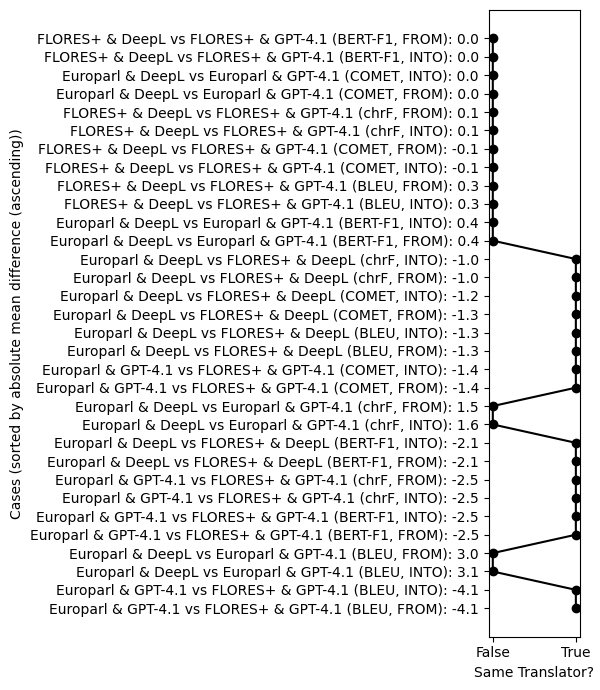

In [17]:
import matplotlib.pyplot as plt
import numpy as np
# ChatGPT Aided
x = np.arange(len(dim_data))
labels = [f'{dx} & {tx} vs {dy} & {ty} ({met}, {m}): {mdiff:.1f}' for dx, tx, dy, ty, met, m, mdiff in zip(dim_data['dataset x'], dim_data['translator x'], dim_data['dataset y'], dim_data['translator y'], dim_data['metric'], dim_data['direction'], dim_data['mean diff'])]
bools = dim_data['same tl'].astype(int)
plt.figure(figsize=(6, 7))
plt.plot(bools, x, marker='o', color='black')
#plt.plot(bools, x, drawstyle='steps-post')
plt.yticks(x, labels)
plt.xticks([0, 1], ['False', 'True'])
plt.ylabel('Cases (sorted by absolute mean difference (ascending))')
plt.xlabel('Same Translator?')
plt.tight_layout()
plt.show()

In [18]:
check = [(dx, tx, dy, ty) for dx, tx, dy, ty in zip(dim_data['dataset x'],
                                                    dim_data['translator x'], dim_data['dataset y'], dim_data['translator y'])]
check_len = len(check)
# Check if all i and i+1 pairs are the same
check = [check[i] == check[i+1] for i in range(0, check_len-1, 2)]
all(check)


True

* Means of corpus difference tend be higher than translator differences
* Translator differences may be more highlighted for BLEU and chrF than BERT-F1 and COMET
* The translation direction is a dominated dimension; the mean difference of translating into and from seems to be similar

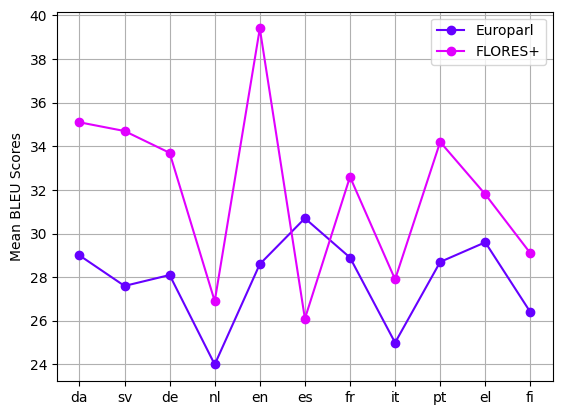

Mean difference: -4.08
Cosine similarity: 0.99


In [19]:
from scripts.presentation import plot_vectors, aggregate_matrices, form_matrices
dx, dy, tx, ty, met, mode = 'ep', 'flores', 'gpt', 'gpt', 'BLEU', 'FROM'
matrices = form_matrices(df, met, [tx, ty], [dx, dy])
agg = aggregate_matrices(matrices, mode=mode, include_base=False)
mean_diff = (agg[f'{dx}-{tx}'] - agg[f'{dy}-{ty}']).mean()
cosine = np.dot(agg[f'{dx}-{tx}'].to_numpy(), agg[f'{dy}-{ty}'].to_numpy()) / (np.linalg.norm(agg[f'{dx}-{tx}'].to_numpy()) * np.linalg.norm(agg[f'{dy}-{ty}'].to_numpy()))
# labels = {'flores-deepl': 'DeepL', 'flores-gpt': 'GPT-4.1'}
# colors = {'flores-deepl': '#D83838', 'flores-gpt': '#39C04B'}

labels = {
    'ep-gpt': 'Europarl',
    'flores-gpt': 'FLORES+',
}
colors = {
    'ep-gpt': "#6600FF",
    'flores-gpt': "#E100FF",
}
plot_vectors(agg, include_base=False, ylabel='Mean BLEU Scores', label_map=labels, color_map=colors)
print(f'Mean difference: {mean_diff:.2f}')
print(f'Cosine similarity: {cosine:.2f}')

# RQ3

## General Patterns in Differences 

In [20]:
from scripts.presentation import aggregate_matrices
import numpy as np
import pandas as pd
data = {
    'dataset x': [],
    'dataset y': [],
    'translator x': [],
    'translator y': [],
    'metric': [],
    'cosine sim': [],
    'mean diff': [],
    'direction': [],
    'same tl': [],
    'same ds': [],
}

combinations = set()
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(
        df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
    for m in ['DIFF']:
        agg = aggregate_matrices(matrices, mode=m, include_base=False)
        for d in ['ep', 'flores']:
            for t in ['deepl', 'gpt']:
                for d2 in ['ep', 'flores']:
                    for t2 in ['deepl', 'gpt']:
                        if (d == d2 and t == t2) or (d != d2 and t != t2):
                            continue

                        comb = (d2, t2, d, t)
                        if comb in combinations:
                            continue
                        vecx = agg[f'{d}-{t}'].to_numpy()
                        vecy = agg[f'{d2}-{t2}'].to_numpy()
                        cosine = np.dot(
                            vecx, vecy) / (np.linalg.norm(vecx) * np.linalg.norm(vecy))
                        diff = (vecx - vecy).mean()
                        data['dataset x'].append(d)
                        data['dataset y'].append(d2)
                        data['translator x'].append(t)
                        data['translator y'].append(t2)
                        data['metric'].append(met)
                        data['cosine sim'].append(cosine)
                        data['mean diff'].append(diff)
                        data['direction'].append(m)
                        data['same tl'].append(t == t2)
                        data['same ds'].append(d == d2)
                        combinations.add((d, t, d2, t2))


labels = {
    'ep': 'Europarl',
    'flores': 'FLORES+',
    'deepl': 'DeepL',
    'gpt': 'GPT-4.1',
}

dim_data = pd.DataFrame(data)
dim_data = dim_data.replace(labels)
dim_data.sort_values(by='mean diff', ascending=False,
                     inplace=True, key=abs, ignore_index=True)
dim_data
# print(dim_data.to_latex(index=False, float_format='%.2f'))

,dataset x,dataset y,translator x,translator y,metric,cosine sim,mean diff,direction,same tl,same ds
0,FLORES+,FLORES+,DeepL,GPT-4.1,BLEU,0.875950,-4.545455e-02,DIFF,False,True
1,Europarl,Europarl,DeepL,GPT-4.1,chrF,0.883821,-3.636364e-02,DIFF,False,True
2,Europarl,Europarl,DeepL,GPT-4.1,BLEU,0.918247,-2.727273e-02,DIFF,False,True
3,Europarl,FLORES+,GPT-4.1,GPT-4.1,BERT-F1,0.757695,-1.818182e-02,DIFF,True,False
4,Europarl,FLORES+,GPT-4.1,GPT-4.1,BLEU,0.731764,-1.818182e-02,DIFF,True,False
5,FLORES+,FLORES+,DeepL,GPT-4.1,BERT-F1,0.943691,-1.818182e-02,DIFF,False,True
6,FLORES+,FLORES+,DeepL,GPT-4.1,chrF,0.906545,-1.818182e-02,DIFF,False,True
7,Europarl,FLORES+,DeepL,DeepL,COMET,0.873465,-1.818182e-02,DIFF,True,False
8,Europarl,FLORES+,GPT-4.1,GPT-4.1,COMET,0.779620,-1.818182e-02,DIFF,True,False
9,Europarl,FLORES+,DeepL,DeepL,chrF,0.786800,-9.090909e-03,DIFF,True,False


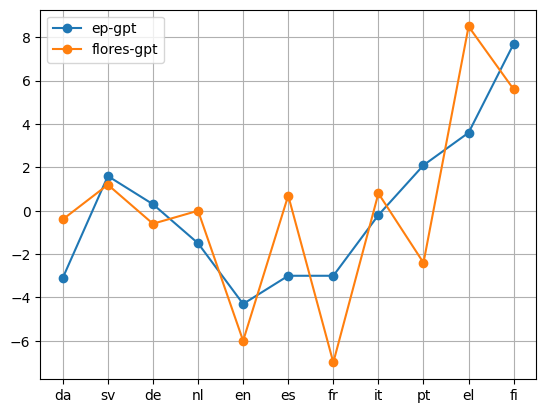

Mean difference: -0.02
Cosine similarity: 0.73


In [21]:
from scripts.presentation import plot_vectors, aggregate_matrices, form_matrices
dx, dy, tx, ty, met, mode = 'ep', 'flores', 'gpt', 'gpt', 'BLEU', 'DIFF'
matrices = form_matrices(df, met, [tx, ty], [dx, dy])
agg = aggregate_matrices(matrices, mode=mode, include_base=False)
mean_diff = (agg[f'{dx}-{tx}'] - agg[f'{dy}-{ty}']).mean()
cosine = np.dot(agg[f'{dx}-{tx}'].to_numpy(), agg[f'{dy}-{ty}'].to_numpy()) / (
    np.linalg.norm(agg[f'{dx}-{tx}'].to_numpy()) * np.linalg.norm(agg[f'{dy}-{ty}'].to_numpy()))
plot_vectors(agg, include_base=False)
print(f'Mean difference: {mean_diff:.2f}')
print(f'Cosine similarity: {cosine:.2f}')

## Translator Differences

In [22]:
from scripts.presentation import aggregate_matrices, form_matrices, matrix_merger
import numpy as np
import pandas as pd
metric2matrices = {}
dim_data = {
    'translator x': [],
    'translator y': [],
    'metric': [],
    'cosine sim': [],
    'mean diff': [],
    'direction': [],
}

met_data_mean_diff = {
    'metric': ['BLEU', 'chrF', 'BERT-F1', 'COMET'],
    'FROM': [],
    'INTO': [],
    'DIFF': [],
}

met_data_cosine = {
    'metric': ['BLEU', 'chrF', 'BERT-F1', 'COMET'],
    'FROM': [],
    'INTO': [],
    'DIFF': [],
}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
    merged = matrix_merger(matrices, 'translator')
    for m in ['INTO', 'FROM', 'DIFF']:
        agg = aggregate_matrices(merged, mode=m, include_base=False)
        vecx = agg['deepl'].to_numpy()
        vecy = agg['gpt'].to_numpy()
        cosine = np.dot(vecx, vecy) / (np.linalg.norm(vecx) * np.linalg.norm(vecy))
        diff = (vecx - vecy).mean()
        dim_data['translator x'].append('deepl')
        dim_data['translator y'].append('gpt')
        dim_data['metric'].append(met)
        dim_data['cosine sim'].append(cosine)
        dim_data['mean diff'].append(diff)
        dim_data['direction'].append(m)
        
        met_data_mean_diff[m].append(diff)
        met_data_cosine[m].append(cosine)
dim_data = pd.DataFrame(dim_data)
dim_data.sort_values(by='mean diff', ascending=False, key=abs, ignore_index=True)
dim_data

,translator x,translator y,metric,cosine sim,mean diff,direction
0,deepl,gpt,BLEU,0.999671,1.663636e+00,INTO
1,deepl,gpt,BLEU,0.999903,1.681818e+00,FROM
2,deepl,gpt,BLEU,0.965682,1.818182e-02,DIFF
3,deepl,gpt,chrF,0.999949,8.090909e-01,INTO
4,deepl,gpt,chrF,0.999983,8.272727e-01,FROM
5,deepl,gpt,chrF,0.953326,1.818182e-02,DIFF
6,deepl,gpt,BERT-F1,0.999995,2.454545e-01,INTO
7,deepl,gpt,BERT-F1,0.999999,2.272727e-01,FROM
8,deepl,gpt,BERT-F1,0.946060,-1.818182e-02,DIFF
9,deepl,gpt,COMET,0.999999,-4.545455e-02,INTO


In [23]:
met_data_mean_diff = pd.DataFrame(met_data_mean_diff)
met_data_mean_diff.set_index('metric', inplace=True)
met_data_mean_diff = met_data_mean_diff[['FROM', 'INTO']]
met_data_mean_diff = met_data_mean_diff.applymap(format_sign)

print(met_data_mean_diff.to_latex(float_format='%.2f'))

\begin{tabular}{lll}
\toprule
 & FROM & INTO \\
metric &  &  \\
\midrule
BLEU & $1.68$ & $1.66$ \\
chrF & $0.83$ & $0.81$ \\
BERT-F1 & $0.23$ & $0.25$ \\
COMET & $-0.05$ & $-0.05$ \\
\bottomrule
\end{tabular}



C:\Users\Kokiri\AppData\Local\Temp\ipykernel_12688\2266176446.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  met_data_mean_diff = met_data_mean_diff.applymap(format_sign)


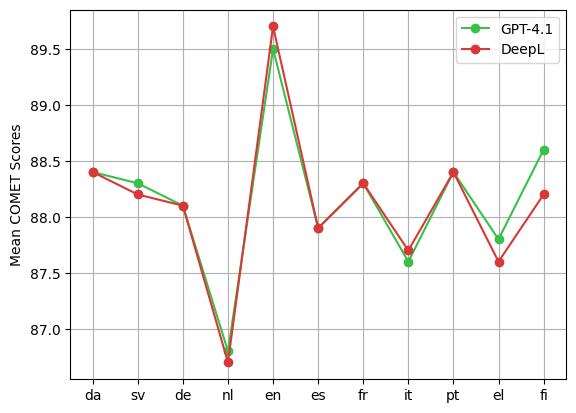

In [24]:
from scripts.presentation import aggregate_matrices, form_matrices, matrix_merger, plot_vectors
met = 'COMET'
matrices = form_matrices(df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
merged = matrix_merger(matrices, 'translator')
agg = aggregate_matrices(merged, mode='FROM', include_base=False)
labels = {
    'deepl': 'DeepL',
    'gpt': 'GPT-4.1',
}
colors = {
    'deepl': '#D83838',
    'gpt': '#39C04B',
}
plot_vectors(agg, include_base=False, ylabel='Mean COMET Scores', label_map=labels, color_map=colors)

## Corpus Differences

In [25]:
from scripts.presentation import aggregate_matrices, form_matrices, matrix_merger
import numpy as np
import pandas as pd
metric2matrices = {}
dim_data = {
    'dataset x': [],
    'dataset y': [],
    'metric': [],
    'cosine sim': [],
    'mean diff': [],
    'direction': [],
}

met_data_mean_diff = {
    'metric': ['BLEU', 'chrF', 'BERT-F1', 'COMET'],
    'FROM': [],
    'INTO': [],
    'DIFF': [],
}

met_data_cosine = {
    'metric': ['BLEU', 'chrF', 'BERT-F1', 'COMET'],
    'FROM': [],
    'INTO': [],
    'DIFF': [],
}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(
        df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
    merged = matrix_merger(matrices, 'dataset')
    for m in ['INTO', 'FROM', 'DIFF']:
        agg = aggregate_matrices(merged, mode=m, include_base=False)
        vecx = agg['ep'].to_numpy()
        vecy = agg['flores'].to_numpy()
        cosine = np.dot(vecx, vecy) / \
            (np.linalg.norm(vecx) * np.linalg.norm(vecy))
        diff = (vecx - vecy).mean()
        dim_data['dataset x'].append('ep')
        dim_data['dataset y'].append('flores')
        dim_data['metric'].append(met)
        dim_data['cosine sim'].append(cosine)
        dim_data['mean diff'].append(diff)
        dim_data['direction'].append(m)

        met_data_mean_diff[m].append(diff)
        met_data_cosine[m].append(cosine)
dim_data = pd.DataFrame(dim_data)
dim_data.sort_values(by='mean diff', ascending=False,
                     key=abs, ignore_index=True)
dim_data

,dataset x,dataset y,metric,cosine sim,mean diff,direction
0,ep,flores,BLEU,0.987981,-2.690909e+00,INTO
1,ep,flores,BLEU,0.994633,-2.672727e+00,FROM
2,ep,flores,BLEU,0.828474,1.818182e-02,DIFF
3,ep,flores,chrF,0.997695,-1.745455e+00,INTO
4,ep,flores,chrF,0.999241,-1.727273e+00,FROM
5,ep,flores,chrF,0.781636,1.818182e-02,DIFF
6,ep,flores,BERT-F1,0.999889,-2.290909e+00,INTO
7,ep,flores,BERT-F1,0.999953,-2.290909e+00,FROM
8,ep,flores,BERT-F1,0.864513,3.875688e-15,DIFF
9,ep,flores,COMET,0.999911,-1.336364e+00,INTO


In [26]:
met_data_mean_diff = pd.DataFrame(met_data_mean_diff)
met_data_mean_diff.set_index('metric', inplace=True)
met_data_mean_diff = met_data_mean_diff[['FROM', 'INTO']]
met_data_mean_diff = met_data_mean_diff.applymap(format_sign)
print(met_data_mean_diff.to_latex(float_format='%.2f'))

\begin{tabular}{lll}
\toprule
 & FROM & INTO \\
metric &  &  \\
\midrule
BLEU & $-2.67$ & $-2.69$ \\
chrF & $-1.73$ & $-1.75$ \\
BERT-F1 & $-2.29$ & $-2.29$ \\
COMET & $-1.34$ & $-1.34$ \\
\bottomrule
\end{tabular}



C:\Users\Kokiri\AppData\Local\Temp\ipykernel_12688\2960829990.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  met_data_mean_diff = met_data_mean_diff.applymap(format_sign)


In [27]:
met_data_cosine = pd.DataFrame(met_data_cosine)
met_data_cosine.set_index('metric', inplace=True)
met_data_cosine

,FROM,INTO,DIFF
metric,,,
BLEU,0.994633,0.987981,0.828474
chrF,0.999241,0.997695,0.781636
BERT-F1,0.999953,0.999889,0.864513
COMET,0.999988,0.999911,0.854841


## Corpus Differences for English

In [28]:
from scripts.presentation import extract_vectors, form_matrices, matrix_merger
import numpy as np
import pandas as pd
dim_data = {
    'dataset x': [],
    'dataset y': [],
    'metric': [],
    'cosine sim': [],
    'mean diff': [],
    'direction': [],
}

met_data_mean_diff = {
    'metric': ['BLEU', 'chrF', 'BERT-F1', 'COMET'],
    'FROM-flores': [],
    'INTO-flores': [],
    'FROM-opus': [],
    'INTO-opus': [],
}

met_data_cosine = {
    'metric': ['BLEU', 'chrF', 'BERT-F1', 'COMET'],
    'FROM-flores': [],
    'INTO-flores': [],
    'FROM-opus': [],
    'INTO-opus': [],

}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(
        df, met, ['deepl', 'gpt']*3, ['ep', 'ep', 'flores', 'flores', 'opus', 'opus'])
    merged = matrix_merger(matrices, 'dataset')
    for m in ['INTO', 'FROM']:
        agg = extract_vectors(merged, mode=m, lang='en', include_base=False)
        vecx = agg['ep'].to_numpy()
        for d in ['flores', 'opus']:
            vecy = agg[d].to_numpy()
            cosine = np.dot(vecx, vecy) / (np.linalg.norm(vecx) * np.linalg.norm(vecy))
            diff = (vecx - vecy).mean()
            dim_data['dataset x'].append('ep')
            dim_data['dataset y'].append(d)
            dim_data['metric'].append(met)
            dim_data['cosine sim'].append(cosine)
            dim_data['mean diff'].append(diff)
            dim_data['direction'].append(m)
            met_data_mean_diff[f'{m}-{d}'].append(diff)
            met_data_cosine[f'{m}-{d}'].append(cosine)
dim_data = pd.DataFrame(dim_data)
dim_data = dim_data.sort_values(by='mean diff', ascending=False, key=abs, ignore_index=True)
dim_data

,dataset x,dataset y,metric,cosine sim,mean diff,direction
0,ep,flores,BLEU,0.989176,-9.94,INTO
1,ep,flores,chrF,0.998062,-8.55,INTO
2,ep,flores,BLEU,0.975037,-8.46,FROM
3,ep,opus,COMET,0.999868,6.15,FROM
4,ep,flores,chrF,0.995962,-5.57,FROM
5,ep,flores,BERT-F1,0.999897,-4.08,INTO
6,ep,flores,COMET,0.999941,-3.92,INTO
7,ep,flores,BERT-F1,0.999756,-3.81,FROM
8,ep,opus,COMET,0.999733,3.77,INTO
9,ep,opus,chrF,0.998494,2.87,INTO


In [29]:
met_data_mean_diff = pd.DataFrame(met_data_mean_diff)
met_data_mean_diff.set_index('metric', inplace=True)
met_data_mean_diff = met_data_mean_diff.applymap(format_sign)
print(met_data_mean_diff.to_latex(float_format='%.2f'))


\begin{tabular}{lllll}
\toprule
 & FROM-flores & INTO-flores & FROM-opus & INTO-opus \\
metric &  &  &  &  \\
\midrule
BLEU & $-8.46$ & $-9.94$ & $-1.76$ & $-1.63$ \\
chrF & $-5.57$ & $-8.55$ & $1.61$ & $2.87$ \\
BERT-F1 & $-3.81$ & $-4.08$ & $1.25$ & $1.49$ \\
COMET & $-1.45$ & $-3.92$ & $6.15$ & $3.77$ \\
\bottomrule
\end{tabular}



C:\Users\Kokiri\AppData\Local\Temp\ipykernel_12688\2528549998.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  met_data_mean_diff = met_data_mean_diff.applymap(format_sign)


In [30]:
met_data_cosine = pd.DataFrame(met_data_cosine)
met_data_cosine.set_index('metric', inplace=True)
met_data_cosine

,FROM-flores,INTO-flores,FROM-opus,INTO-opus
metric,,,,
BLEU,0.975037,0.989176,0.998942,0.997010
chrF,0.995962,0.998062,0.999539,0.998494
BERT-F1,0.999756,0.999897,0.999914,0.999890
COMET,0.999896,0.999941,0.999868,0.999733


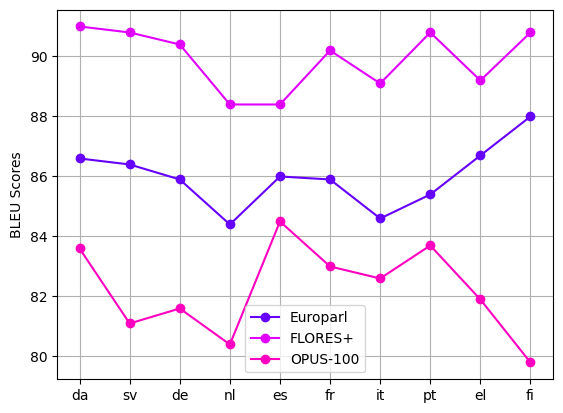

In [31]:
from scripts.presentation import extract_vectors, form_matrices, matrix_merger, plot_vectors
met = 'COMET'
matrices = form_matrices(
    df, met, ['deepl', 'gpt']*3, ['ep', 'ep', 'flores', 'flores', 'opus', 'opus'])
merged = matrix_merger(matrices, 'dataset')
agg = extract_vectors(merged, mode='INTO', include_base=False)
labels = {
    'ep': 'Europarl',
    'flores': 'FLORES+',
    'opus': 'OPUS-100',

}
colors = {
    'ep': "#6600FF",
    'flores': "#E100FF",
    'opus': "#FF00C0",
}
plot_vectors(agg, include_base=False, ylabel='BLEU Scores',
             label_map=labels, color_map=colors)

## Outliers per Metric

In [32]:

from scripts.presentation import aggregate_matrices
from collections import Counter
import pandas as pd
data = {
    'dataset': [],
    'translator': [],
    'metric': [],
    'direction': [],
    'mean': [],
    'SD': [],
    'high outliers': [],
    'low outliers': [],
}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(
        df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
    for m in ['INTO', 'FROM']:
        agg = aggregate_matrices(matrices, mode=m, include_base=False)
        for d in ['ep', 'flores']:
            for t in ['deepl', 'gpt']:
                focus = agg[f'{d}-{t}']
                mean = focus.mean()
                std = focus.std()
                outliers = focus[abs(focus - mean) > std]
                high_outliers = outliers[outliers > mean].index.tolist()
                low_outliers = outliers[outliers < mean].index.tolist()
                data['dataset'].append(d)
                data['translator'].append(t)
                data['metric'].append(met)
                data['direction'].append(m)
                data['mean'].append(mean)
                data['SD'].append(std)
                data['high outliers'].append(high_outliers)
                data['low outliers'].append(low_outliers)
                


labels = {
    'ep': 'Europarl',
    'flores': 'FLORES+',
    'deepl': 'DeepL',
    'gpt': 'GPT-4.1',
}

dim_data = pd.DataFrame(data)
outliers_into = dim_data[dim_data['direction'] == 'INTO']
outliers_from = dim_data[dim_data['direction'] == 'FROM']
dim_data = dim_data.replace(labels)
dim_data = dim_data.map(format_as_latex_set)
print(dim_data.to_latex(index=False, float_format='%.2f'))
dim_data

\begin{tabular}{llllrrll}
\toprule
dataset & translator & metric & direction & mean & SD & high outliers & low outliers \\
\midrule
Europarl & DeepL & BLEU & INTO & 30.93 & 4.46 & \{en, es, fr\} & \{fi\} \\
Europarl & GPT-4.1 & BLEU & INTO & 27.85 & 4.46 & \{en, es\} & \{fi\} \\
FLORES+ & DeepL & BLEU & INTO & 32.22 & 6.95 & \{en, fr\} & \{es, el, fi\} \\
FLORES+ & GPT-4.1 & BLEU & INTO & 31.92 & 7.21 & \{en, fr\} & \{el, fi\} \\
Europarl & DeepL & BLEU & FROM & 30.92 & 2.28 & \{en, es\} & \{nl, it\} \\
Europarl & GPT-4.1 & BLEU & FROM & 27.87 & 2.00 & \{es\} & \{nl, it\} \\
FLORES+ & DeepL & BLEU & FROM & 32.21 & 3.77 & \{en\} & \{nl, es, it\} \\
FLORES+ & GPT-4.1 & BLEU & FROM & 31.95 & 4.07 & \{en\} & \{nl, es\} \\
Europarl & DeepL & chrF & INTO & 58.88 & 2.36 & \{en, fr\} & \{el\} \\
Europarl & GPT-4.1 & chrF & INTO & 57.32 & 2.53 & \{es, fr\} & \{el, fi\} \\
FLORES+ & DeepL & chrF & INTO & 59.87 & 5.15 & \{en\} & \{es, el\} \\
FLORES+ & GPT-4.1 & chrF & INTO & 59.79 & 5.36 & \{en\

,dataset,translator,metric,direction,mean,SD,high outliers,low outliers
0,Europarl,DeepL,BLEU,INTO,30.927273,4.456252,"\{en, es, fr\}",\{fi\}
1,Europarl,GPT-4.1,BLEU,INTO,27.854545,4.459454,"\{en, es\}",\{fi\}
2,FLORES+,DeepL,BLEU,INTO,32.218182,6.945188,"\{en, fr\}","\{es, el, fi\}"
3,FLORES+,GPT-4.1,BLEU,INTO,31.918182,7.209136,"\{en, fr\}","\{el, fi\}"
4,Europarl,DeepL,BLEU,FROM,30.918182,2.276321,"\{en, es\}","\{nl, it\}"
5,Europarl,GPT-4.1,BLEU,FROM,27.872727,2.001545,\{es\},"\{nl, it\}"
6,FLORES+,DeepL,BLEU,FROM,32.209091,3.773448,\{en\},"\{nl, es, it\}"
7,FLORES+,GPT-4.1,BLEU,FROM,31.954545,4.071944,\{en\},"\{nl, es\}"
8,Europarl,DeepL,chrF,INTO,58.881818,2.361279,"\{en, fr\}",\{el\}
9,Europarl,GPT-4.1,chrF,INTO,57.318182,2.528564,"\{es, fr\}","\{el, fi\}"


In [33]:
high_outliers_into = [o for o in outliers_into['high outliers'] if o]
high_outliers_into = Counter([item for sublist in high_outliers_into for item in sublist])
low_outliers_into = [o for o in outliers_into['low outliers'] if o]
low_outliers_into = Counter([item for sublist in low_outliers_into for item in sublist])
high_outliers_from = [o for o in outliers_from['high outliers'] if o]
high_outliers_from = Counter([item for sublist in high_outliers_from for item in sublist])
low_outliers_from = [o for o in outliers_from['low outliers'] if o]
low_outliers_from = Counter([item for sublist in low_outliers_from for item in sublist])

print(
    f'High outliers INTO: {high_outliers_into}\n'
    f'Low outliers INTO: {low_outliers_into}\n'
    f'High outliers FROM: {high_outliers_from}\n'
    f'Low outliers FROM: {low_outliers_from}\n'
)

High outliers INTO: Counter({'en': 11, 'fr': 6, 'es': 5, 'fi': 4, 'el': 2})
Low outliers INTO: Counter({'el': 9, 'fi': 8, 'es': 5, 'nl': 1, 'pt': 1})
High outliers FROM: Counter({'en': 12, 'es': 6, 'el': 1})
Low outliers FROM: Counter({'nl': 16, 'it': 9, 'es': 7, 'fi': 1, 'el': 1})



# Experimental

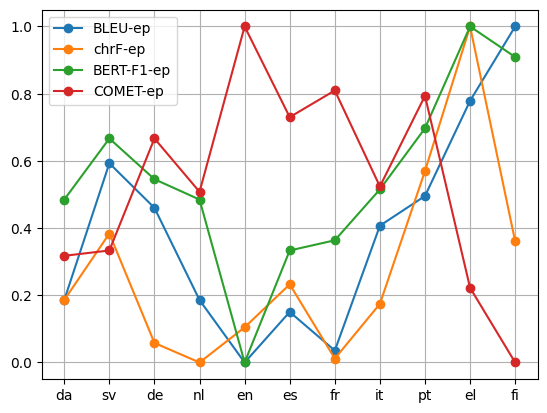

chrF-ep: 0.84
BERT-F1-ep: 0.95
COMET-ep: 0.48


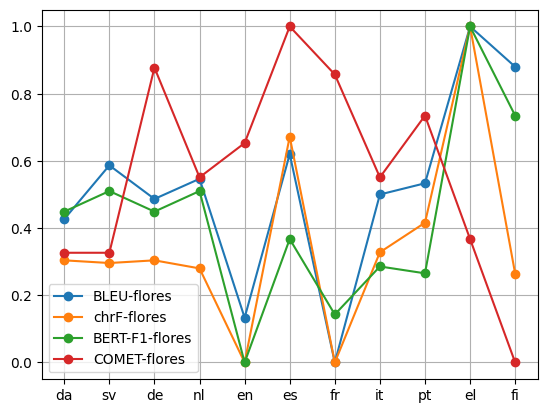

chrF-flores: 0.93
BERT-F1-flores: 0.97
COMET-flores: 0.69


In [34]:
from scripts.presentation import plot_vectors, aggregate_matrices, matrix_merger
import numpy as np
import pandas as pd


def min_max_norm(vec):
    amin = vec.min()
    amax = vec.max()
    return (vec - amin) / (amax - amin)

metric2matrices = {}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
    metric2matrices[met] = matrices
    
metric2means = {}
for met in metric2matrices:
    matrices = metric2matrices[met]
    merged = matrix_merger(matrices, 'dataset')
    for m in ['DIFF']:
        agg = aggregate_matrices(merged, mode=m, include_base=False)
        for t in ['ep', 'flores']:
            metric2means[f'{met}-{t}'] = agg[t]

metric2means['base'] = aggregate_matrices(
        metric2matrices['BLEU'], mode='DIFF', include_base=False)['base']
for d in ['ep', 'flores']:
    metric2means_up = {k:min_max_norm(v) for k, v in metric2means.items() if k.endswith(d)}
    metric2means_up['base'] = metric2means['base']
    metric2means_up = pd.DataFrame(metric2means_up)
    plot_vectors(metric2means_up, include_base=False)
    for m in metric2means_up:
        if 'BLEU' in m or m=='base': continue
        other_vec = metric2means_up[m].to_numpy()
        bleu_vec = metric2means_up[f'BLEU-{d}'].to_numpy()
        cosine = np.dot(bleu_vec, other_vec) / (np.linalg.norm(bleu_vec) * np.linalg.norm(other_vec))
        print(f'{m}: {cosine:.2f}')

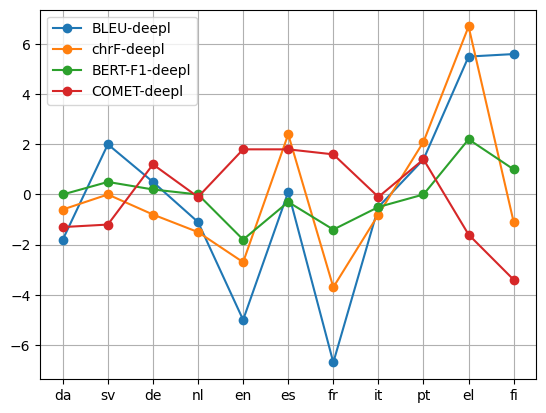

chrF-deepl: 0.70
BERT-F1-deepl: 0.92
COMET-deepl: -0.69


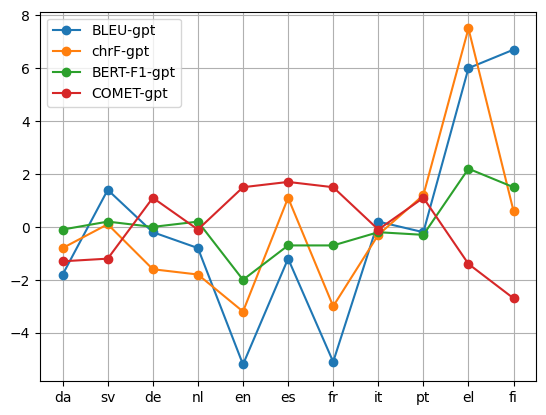

chrF-gpt: 0.75
BERT-F1-gpt: 0.92
COMET-gpt: -0.78


In [35]:
from scripts.presentation import plot_vectors, aggregate_matrices, matrix_merger
import numpy as np
import pandas as pd
metric2matrices = {}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    matrices = form_matrices(
        df, met, ['deepl', 'gpt']*2, ['ep', 'ep', 'flores', 'flores'])
    metric2matrices[met] = matrices

metric2means = {}
for met in metric2matrices:
    matrices = metric2matrices[met]
    merged = matrix_merger(matrices, 'translator')
    for m in ['DIFF']:
        agg = aggregate_matrices(merged, mode=m, include_base=False)
        for t in ['deepl', 'gpt']:
            metric2means[f'{met}-{t}'] = agg[t]

metric2means['base'] = aggregate_matrices(
    metric2matrices['BLEU'], mode='DIFF', include_base=False)['base']
for d in ['deepl', 'gpt']:
    metric2means_up = {k: v for k, v in metric2means.items()
                       if k.endswith(d) or k == 'base'}
    metric2means_up = pd.DataFrame(metric2means_up)
    plot_vectors(metric2means_up, include_base=False)
    for m in metric2means_up:
        if 'BLEU' in m or m == 'base':
            continue
        other_vec = metric2means_up[m].to_numpy()
        bleu_vec = metric2means_up[f'BLEU-{d}'].to_numpy()
        cosine = np.dot(bleu_vec, other_vec) / \
            (np.linalg.norm(bleu_vec) * np.linalg.norm(other_vec))
        print(f'{m}: {cosine:.2f}')